In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler # Besser als MinMax hier
from scipy import stats

In [15]:
# 1. Daten Laden
df = pd.read_csv('allData.csv')

# 2. WICHTIG: Vorfilterung der Ausreißer (Clean Data)
# Wir wollen Asteroidenfamilien finden, keine Kometen in der Oortschen Wolke.
# Behalten wir nur Objekte innerhalb von 10 AU (Jupiter ist bei 5.2)
df_clean = df[(df['a'] < 10) & (df['a'] > 1.0)].copy()

# Features auswählen
features = ['a', 'e', 'i']
X_original = df_clean[features].dropna()

c:\Users\leon-\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (17,23,24,25,36,43,44) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [16]:
# 3. Skalieren (StandardScaler ist robuster gegen leichte Ausreißer als MinMax)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_original)

# 4. Clustering auf den SKALIERTEN Daten
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10) # k=4 ist oft gut für den Anfang
cluster_labels = kmeans.fit_predict(X_scaled)

# Die Labels an die ORIGINAL-Daten hängen zum Plotten
X_original['cluster'] = cluster_labels

TypeError: mode() got an unexpected keyword argument 'keepdims'

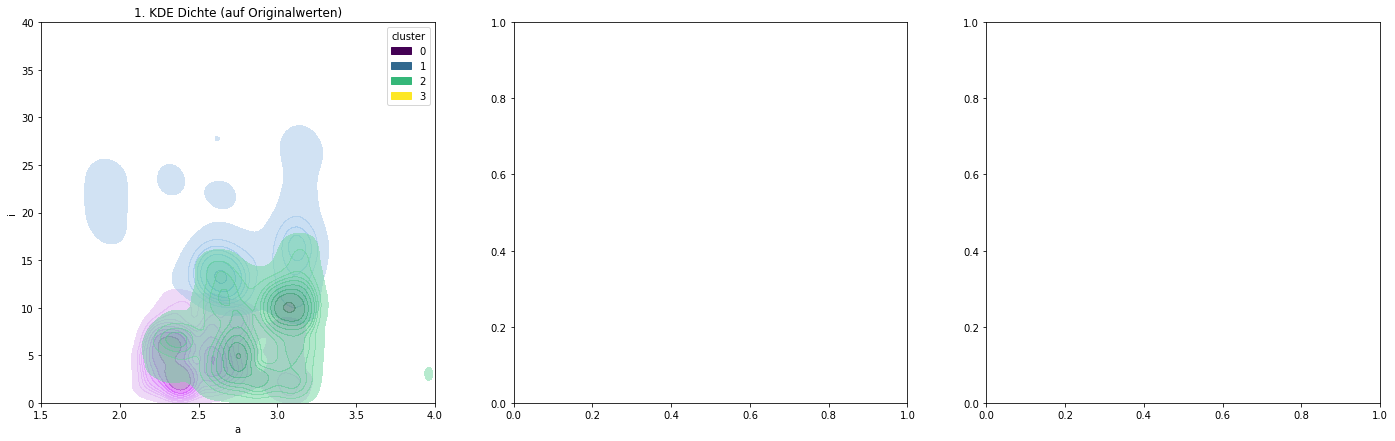

In [17]:
# --- PLOTTING (Wir plotten X_original, NICHT X_scaled!) ---

fig, axes = plt.subplots(1, 3, figsize=(24, 7))

# Sampling für Performance (Plotten dauert sonst ewig)
X_plot = X_original.sample(n=50000, random_state=42) if len(X_original) > 50000 else X_original

# --- PLOT 1: KDE (Dichte) ---
sns.kdeplot(
    data=X_plot, 
    x='a', y='i', 
    hue='cluster', 
    palette='viridis', 
    fill=True, 
    alpha=0.5, 
    levels=10, # Weniger Levels = schneller
    ax=axes[0]
)
axes[0].set_title('1. KDE Dichte (auf Originalwerten)')
axes[0].set_xlim(1.5, 4.0) # Jetzt machen diese Limits Sinn!
axes[0].set_ylim(0, 40)

# --- PLOT 2: Hexbin ---
def get_dominant_cluster(x):
    if len(x) == 0: return np.nan
    # Modus berechnen (Cluster der am häufigsten in der Wabe vorkommt)
    return stats.mode(x, keepdims=False)[0]

# Hier nutzen wir das ganze Dataset (X_original), Hexbin ist schnell!
hb = axes[1].hexbin(
    X_original['a'], X_original['i'], 
    C=X_original['cluster'],    
    reduce_C_function=get_dominant_cluster, 
    gridsize=150, 
    cmap='tab10',       
    mincnt=1,
    extent=[1.5, 4.0, 0, 40] # Setzt Limits direkt im Hexbin
)
axes[1].set_title('2. Hexbin: Dominanter Cluster')
axes[1].set_xlabel('Große Halbachse (a) [AU]')
cb = plt.colorbar(hb, ax=axes[1], ticks=range(4))
cb.set_label('Cluster ID')

# --- PLOT 3: Scatter (Physikalisch) ---
sns.scatterplot(
    data=X_plot, 
    x='a', y='i', 
    hue='cluster', 
    palette='viridis', 
    s=3, 
    alpha=0.3, 
    ax=axes[2], 
    legend='full'
)
axes[2].set_title('3. Scatter (Sample)')
axes[2].set_xlim(1.5, 4.0)
axes[2].set_ylim(0, 40)

plt.tight_layout()
plt.show()

# Statistik prüfen (sollte jetzt echte Werte in AU zeigen)
print("Cluster-Statistiken (Mittelwerte in echten Einheiten):")
print(X_original.groupby('cluster')[['a', 'e', 'i']].mean())

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import os

# ---------------------------------------------------------
# 1. Daten vorbereiten (Sampling für Performance)
# ---------------------------------------------------------

# Prüfen, ob X_original schon existiert, sonst laden (Sicherheitsnetz)
if 'X_original' not in locals():
    try:
        # Pfad ggf. anpassen
        df = pd.read_csv('clustering/GPT.csv') # Oder 'allData.csv'
        # Filter für Hauptgürtel (wie in deinem Projekt)
        df_clean = df[(df['a'] < 10) & (df['a'] > 1.0)].copy()
        X_original = df_clean[['a', 'e', 'i']].dropna()
    except:
        print("Bitte führe zuerst den Code zum Laden der Daten aus (Zelle 1 & 2) oder prüfe den Dateipfad.")

# SAMPLE NEHMEN! (Das ist der Trick für Geschwindigkeit)
# Wenn mehr als 500k Daten da sind, nehmen wir zufällig 500.000
if len(X_original) > 400000:
    print(f"Datensatz hat {len(X_original)} Punkte. Erstelle Sample von 400.000 Punkten...")
    X_sample = X_original.sample(n=400000, random_state=42).copy()
else:
    print(f"Verwende kompletten Datensatz mit {len(X_original)} Punkten.")
    X_sample = X_original.copy()

# Skalieren (Nur auf dem Sample!)
scaler = StandardScaler()
X_sample_scaled = scaler.fit_transform(X_sample)

# ---------------------------------------------------------
# 2. DBSCAN Algorithmus (Optimiert)
# ---------------------------------------------------------
print("Starte DBSCAN Clustering...")

# n_jobs=-1 nutzt alle CPU-Kerne
dbscan = DBSCAN(eps=0.3, min_samples=10, n_jobs=-1)
db_labels = dbscan.fit_predict(X_sample_scaled)

# Labels an das SAMPLE hängen
X_sample['dbscan_cluster'] = db_labels

# ---------------------------------------------------------
# 3. Export als CSV
# ---------------------------------------------------------
output_filename = 'clustered_families_dbscan.csv'
# Sicherstellen, dass der Ordner existiert
X_sample.to_csv(output_filename, index=False)
print(f"Ergebnisse wurden erfolgreich in '{output_filename}' gespeichert.")

# ---------------------------------------------------------
# 4. Statistiken
# ---------------------------------------------------------
n_clusters_ = len(set(db_labels)) - (1 if -1 in db_labels else 0)
n_noise_ = list(db_labels).count(-1)
noise_percent = (n_noise_ / len(db_labels)) * 100

print(f"--- DBSCAN Ergebnis ---")
print(f"Gefundene Familien (Cluster): {n_clusters_}")
print(f"Rauschen (Hintergrund-Asteroiden): {n_noise_} ({noise_percent:.1f}%)")

# ---------------------------------------------------------
# 5. Visualisierung (a vs i)
# ---------------------------------------------------------
plt.figure(figsize=(12, 7))

# Daten aufteilen für sauberen Plot
mask_noise = X_sample['dbscan_cluster'] == -1
noise_data = X_sample[mask_noise]
cluster_data = X_sample[~mask_noise]

# 1. Rauschen plotten (grau, klein, transparent)
plt.scatter(noise_data['a'], noise_data['i'], 
            c='lightgray', s=1, alpha=0.3, label='Rauschen')

# 2. Cluster plotten (bunt)
# cmap='nipy_spectral' bietet hohen Kontrast für viele Cluster
scatter = plt.scatter(cluster_data['a'], cluster_data['i'], 
                      c=cluster_data['dbscan_cluster'], 
                      cmap='nipy_spectral', s=5, alpha=0.8)

plt.title(f'Asteroidenfamilien mit DBSCAN (Sample n={len(X_sample)})\nEps=0.3, Min_Samples=10 | Cluster: {n_clusters_}')
plt.xlabel('Große Halbachse (a) [AU]')
plt.ylabel('Inklination (i) [Grad]')
plt.xlim(1.5, 4.0)
plt.ylim(0, 35)
plt.colorbar(scatter, label='Cluster ID')
plt.legend(markerscale=5)
plt.grid(True, alpha=0.3)
plt.show()

Bitte führe zuerst den Code zum Laden der Daten aus (Zelle 1 & 2) oder prüfe den Dateipfad.


NameError: name 'X_original' is not defined

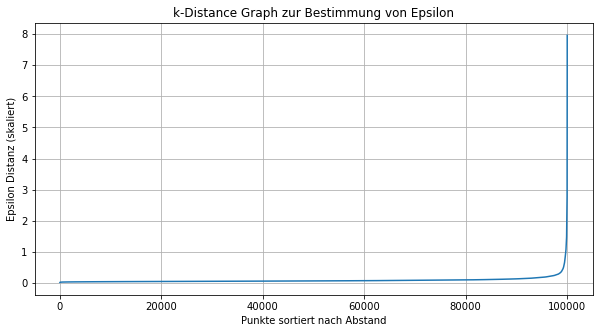

In [20]:
from sklearn.neighbors import NearestNeighbors

# Berechne Abstände zu den k nächsten Nachbarn
neigh = NearestNeighbors(n_neighbors=10)
nbrs = neigh.fit(X_sample_scaled)
distances, indices = nbrs.kneighbors(X_sample_scaled)

# Sortiere und plotte die Abstände
distances = np.sort(distances[:, 9], axis=0) # neunter Nachbar (Index 9)
plt.figure(figsize=(10, 5))
plt.plot(distances)
plt.title("k-Distance Graph zur Bestimmung von Epsilon")
plt.xlabel("Punkte sortiert nach Abstand")
plt.ylabel("Epsilon Distanz (skaliert)")
plt.grid()
plt.show()

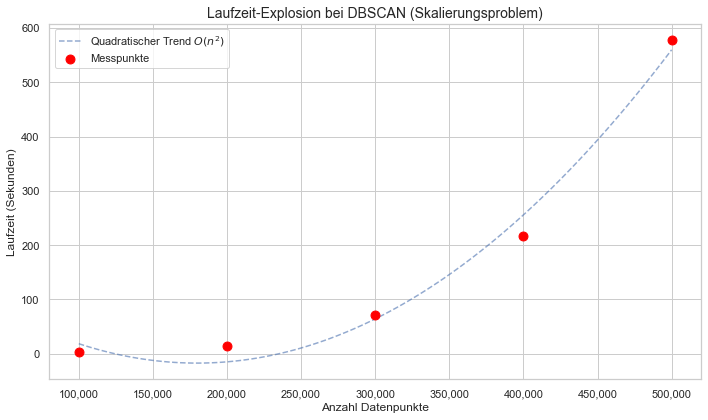

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Daten vorbereiten
samples = np.array([100000, 200000, 300000, 400000, 500000])
# Zeit in Sekunden umrechnen: 9m 38s = 578s
times = np.array([2.6, 15, 71, 217, 578])

# Design
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

# 1. Trendlinie berechnen (Polynom 2. Grades = Quadratisch)
# Das zeigt mathematisch, dass es sich um O(n^2) handelt
z = np.polyfit(samples, times, 2)
p = np.poly1d(z)
x_trend = np.linspace(min(samples), max(samples), 100)

# 2. Plotten
plt.plot(x_trend, p(x_trend), 'b--', label='Quadratischer Trend $O(n^2)$', alpha=0.6)
plt.scatter(samples, times, color='red', s=80, zorder=5, label='Messpunkte')

# 3. Beschriftung
plt.title('Laufzeit-Explosion bei DBSCAN (Skalierungsproblem)', fontsize=14)
plt.xlabel('Anzahl Datenpunkte', fontsize=12)
plt.ylabel('Laufzeit (Sekunden)', fontsize=12)
plt.legend()

# Achsen formatieren
plt.gca().get_xaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

plt.tight_layout()
plt.show()